In [1]:
import numpy as np
import scipy as sp
from scipy import ndimage
import matplotlib.pyplot as plt  # for imshow
import matplotlib.colors as colors
import matplotlib.patches as patches
from scipy.cluster import vq     # for k-means and vq
import random

%matplotlib inline

[[ 0.7526756   1.07330391  0.94006028 ... -0.45398268  0.55104054
   0.71838378]
 [ 1.04742869  0.0676551   1.12713437 ... -0.1726036   0.75441901
   1.11802408]
 [ 0.36514372 -1.74059599  0.17066832 ... -0.35604493  0.45421942
   1.09272167]
 ...
 [-1.21014615 -1.58046296 -0.39377099 ...  1.26142452  0.54569427
   0.72211687]
 [-0.59742454 -0.56195593 -0.38090467 ...  0.13629036  0.84203243
   0.4680244 ]
 [-0.19870765  0.25150053 -0.49576423 ... -0.81078899 -0.30347792
  -0.44291795]]


(-0.5, 255.5, 255.5, -0.5)

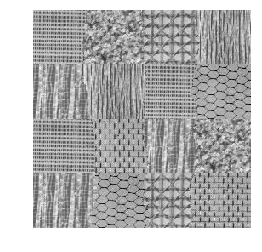

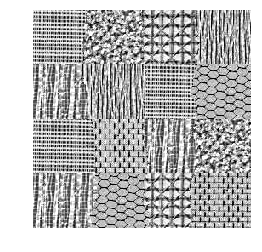

In [3]:
im = plt.imread('patchwork1.jpg')
im = im/255    # convert to float in interval [0 1]
gim = np.mean(im[:,:,0:3],axis=2)    # find mean of RGB to create a 2D grayscale image (could be RGBA)

#when it is grayscale image, directly use this instead of meaning
#gim = im

plt.imshow(gim, cmap='gray')
plt.axis('off')

# perform local contrast normalisation
sgim = ndimage.gaussian_filter(gim,4)    # smooth the intensity image ('reflect' at boundaries) fast divide 1D, 4 is standard deviation(larger, more obvious)
dev = (gim-sgim)     #original mean - extracted 1D
V = ndimage.gaussian_filter(dev*dev,4)    # smooth the variance
gim = dev / np.maximum(np.sqrt(V), 0.1)

# Gray-levels are no longer in the interval [0 1], so provide normalisation to imshow
print(gim)
#print(dev)

plt.figure()
norm = colors.Normalize(vmin=gim.min()/2, vmax=gim.max()/2)
plt.imshow(gim, cmap='gray', norm=norm)
plt.axis('off')

#------------------------------------------------------------------------------------------------

(-0.5, 243.5, 243.5, -0.5)

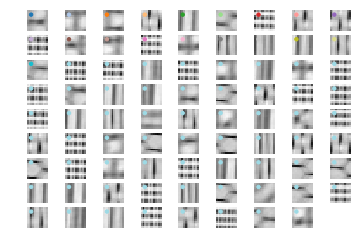

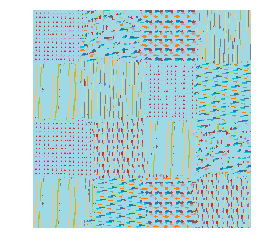

In [4]:
#learn features
N = 12      # size of patch
K = 80       # number of prototypes for kmeans
P = 20000   # number of randomly selected patches

R = gim.shape[0]    # number of rows in image = 256
C = gim.shape[1]    # number of columns in image = 256

#original patches, 20000*625
X = np.zeros((P,N*N),dtype=float) # initialise array for random patches

for i in range(0, P):                   #do the loop from 0-20000
    r = random.randint(0,R-N)    #r = random int from 0 to R-N=256-25=231
    c = random.randint(0,C-N)     #c = random int from 0 to C-N=256-25=231
    patch = gim[r:r+N,c:c+N]      #slice gim from row r to (r+25)，column from c to (c+N), return patch, 25*25 array
    X[i,:] = np.reshape(patch,(-1))   #replace patch, because don't know original patch has how many rows and columns, use -1 to replace the number of rows and columns, return a row of array without dividing rows

    
#kmeans on X
#divide X into k(=9) clusters, return codebook--an array composed of centroids, distortion--error sum of squares between centroids and observations
codebook, distortion = vq.kmeans(X,K)

spn = np.ceil(np.sqrt(K))    # size of subplot display, spn=the biggest number<sqrt(K)=3
norm = colors.Normalize(vmin=codebook.min(), vmax=codebook.max())    # set gray range from minimum to maximum
for i in range(0,K):            #do the loop from 0-K
    plt.subplot(spn,spn,i+1)         
    plt.imshow(np.reshape(codebook[i,:],(N,N)),cmap='gray',norm=norm)         #reshape codebook into 25*25, color is gray
    plt.gca().add_patch(patches.Circle((2,2), radius=1, color=plt.cm.tab20(i)))     #visualize patches with a color-filled circle
    plt.axis('off')    # turn off the axes
    
#------------------------------------------------------------------------------------------------
#produce labels
#initialise array for all patches, row = 231*231, column = 25*25
X = np.zeros(((R-N)*(C-N),N*N),dtype=float)   

i=0
for r in range(0,R-N):
    for c in range(0,C-N):
        X[i,:] = np.reshape(gim[r:r+N,c:c+N],(-1))     #reshape each array sliced from gim into 1 row
        i=i+1

        
#input X and clustered centroids--codebook, return code--each point is clustered into which cluster, dist--error sum of squares
code, dist = vq.vq(X,codebook)

#reshape code (labels of features) into 231*231
code = np.reshape(code,(R-N,C-N))    # reshape the 1D code array into the original 2D image shape


# to give each label a unique colour, turn off normalisation in order to index directly into discrete colour map
plt.figure()
norm = colors.NoNorm()
plt.imshow(code, cmap='tab20', norm=norm)
plt.axis('off')    # turn off the axes

#------------------------------------------------------------------------------------------------

In [5]:
#observe code, the number of rows and columns
print(code)

Rcode = code.shape[0]    # number of rows in image = R-N
Ccode = code.shape[1]    # number of columns in image = C-N

print(Rcode)
print(Ccode)

#------------------------------------------------------------------------------------

[[27  9  9 ... 14 15 38]
 [35 55 19 ... 14 15 17]
 [71 58 46 ... 14 15 17]
 ...
 [ 4 37 37 ... 52 76 76]
 [ 4 37 37 ... 52 76 76]
 [ 4 37 37 ...  8 76 65]]
244
244


In [6]:
#use a window (which size is M*M) to traverse and slice the labels of image
#generate the histograms of labels which counts the number of each kind of labels

M = 20
bincountnumber = K    #the number of bincount which should be same to K

#initialize the bincount matrix
rows = np.zeros((bincountnumber,), dtype=int)
count_matrix = np.zeros((bincountnumber,), dtype=int)
#print(rows)
#print(count_matrix)


#generate the histogram of labels
for r in range(0, R-N-M+1):     #row from 0 to R-N-M
    if r <=R-N-M+1:
        for c in range(0, C-N-M+1):    #column from 0 to C-N-M
            if c<=C-N-M+1:
                subcode = code[r:r+M,c:c+M]    #slice code(labels)
                #print(subcode)
                rows = np.zeros((bincountnumber,), dtype=int)

                for i in range(0, M):   #count the number of each kind of labels
                    
                    row = np.bincount(subcode[i,:], minlength = bincountnumber)
                    #print(row)
                    rows = np.row_stack((rows, row))
                    #print(rows)
                count = rows.sum(axis=0)
                #print(count)
                count_matrix = np.row_stack((count_matrix, count))
                #print(count_matrix)
            else:
                break
    else:
        break

count_matrix = count_matrix[1:, :]    #drop the first row like [000000000]
print(count_matrix)

Rcm = count_matrix.shape[0]    # number of rows in count_matirx
Ccm = count_matrix.shape[1]    # number of columns in count_matirx
print(Rcm)   
print(Ccm)   #K columns

#--------------------------------------------------------------------------------

[[ 0  0  0 ... 25  0  0]
 [ 0  0  0 ... 24  0  0]
 [ 0  0  0 ... 23  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
50625
80


(-0.5, 224.5, 224.5, -0.5)

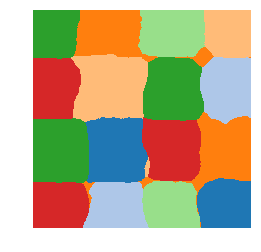

In [7]:
#set the number of clustering histograms which is the number of distinct textures observed in the source image
K2 = 7

#transfer int to float in count_matrix
count_matrix = [[float(i) for i in inner] for inner in count_matrix]
#print(count_matrix)

#cluster the histograms count_matrix into K2 clusters, return codebook_final is the centroids of clustered histograms
codebook_final, dist_final = vq.kmeans(count_matrix, K2)
#print(codebook_final)

#return code_final to get each histogram is clustered into which cluster
code_final, dist_final = vq.vq(count_matrix, codebook_final)
#print(code_final)

#reshape code_final
code_final = np.reshape(code_final, (R-N-M+1, C-N-M+1))

#visualize the cluster result
plt.figure()
norm = colors.NoNorm()
plt.imshow(code_final, cmap='tab20', norm=norm)
plt.axis('off')    # turn off the axes
